## Warehouse Box Stacking Robots
Box stacking inside a warehouse full of boxes with 5 robots.

### Report
The simulation of the robots stacking boxes to organize the garage could be improved since it only tries to find a better place to stack each box if it has not yet reached the maximum stacking limit. In case of designating specific spaces for all the robots to stack the boxes, the solution could be achieved in a faster way, however, since the boxes start in random positions, a solution as organized as possible is desired, knowing that it is not possible to know from the beginning if there are clear paths for the robots to reach the same position and stack the boxes in the same place.

Considering that the conditions are going to be changing, the cleaning algorithm implemented ensures a good level of organization of the boxes inside the warehouse at all times respecting real life factors such as that robots cannot pass over each other or form a path through the boxes. To achieve this, the solution considers both robots and stacks of boxes as agents that make it impossible to move through cells containing each of the above agents.

It would be better to implement informed movements in which only cells that have not been visited before are visited and to inform other robots that a stack is beign formed in a specific location for them to colaborate and reach the stacking limit faster.


In [16]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
# Function to activate agents randomly one after another
from mesa.time import RandomActivation
# Create grid which allows one agent at a time per cell
from mesa.space import SingleGrid
# Obtain information from each step of the simulation
from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [17]:
# Function to plot grid with robots and stacked boxes.
# Receives model, returns grid
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    # Loop grid from model
    for (content, x, y) in model.grid.coord_iter():
        if content != None:
            if content.type == "Robot":
                grid[x][y] = 6
            elif content.type == "Box":
                grid[x][y] = content.actual_stack

    return grid

# Agent that represents a stack of boxes
class BoxAgent(Agent):
    def __init__(self, unique_id, model, box_stack_limit):
        super().__init__(unique_id, model)

        self.type = "Box"
        self.stack_limit = box_stack_limit
        self.actual_stack = 1


# Agent that represents the robot
class StackingRobot(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

        self.type = "Robot"
        self.box = False
        self.min_stack = 1
        self.attempts = 0

    # Function that moves the robot, transports box and stacks box
    def move(self):
        # Get cell neighbors
        neighbors = self.model.grid.get_neighbors(self.pos, moore = False, include_center = False)
        moved_box = False
        # Determine best box stack to move
        min_stack = 4
        if not self.box:
            for neighbor in neighbors:
                if neighbor.type == "Box":
                    min_stack = min(min_stack, neighbor.actual_stack)

        for neighbor in neighbors:
            if not moved_box:
                # Not moving box, move best option to stack
                if not self.box and neighbor.type == "Box" and neighbor.actual_stack == min_stack:
                    self.box = True
                    moved_box = True
                    self.min_stack = neighbor.actual_stack
                    neighbor.actual_stack -= 1
                    if neighbor.actual_stack == 0:
                        self.model.grid.remove_agent(neighbor)
                # Stack box if better option from where it was removed
                elif self.box and neighbor.type == "Box" and neighbor.actual_stack < neighbor.stack_limit and neighbor.actual_stack >= self.min_stack:
                    self.box = False
                    moved_box = True
                    neighbor.actual_stack += 1
                    if neighbor.actual_stack == neighbor.stack_limit:
                        self.model.full_stacks += 1
                # Reduce complexity if it has tried more than 3 times without exit
                elif self.attempts >= 3 and self.box and neighbor.type == "Box" and neighbor.actual_stack < neighbor.stack_limit:
                    self.min_stack -= 1
                    self.attempts = 0
                # Count fail attempts
                elif self.box and neighbor.type == "Box" and neighbor.actual_stack < neighbor.stack_limit:
                    self.attempts += 1

        # Move robot to empty cell
        possible_moves = self.model.grid.get_neighborhood(self.pos, moore = False, include_center = False)
        move = self.random.choice(possible_moves)
        moves = len(possible_moves) * 4
        while moves >= 0 and not self.model.grid.is_cell_empty(move):
            move = self.random.choice(possible_moves)
            moves -= 1
        if self.model.grid.is_cell_empty(move):
            self.model.grid.move_agent(self, move)
            self.model.num_total_moves += 1
        else:
            self.model.num_invalid_moves += 1


    # Each step of simulation robot tries to move box and move inside warehouse
    def step(self):
        self.move()


# Model of warehouse box stacking robot
# Receives height and width of warehouse, number of robots and percentage of boxes inside
class CleaningModel(Model):
    def __init__(self, height, width, n_robots, p_boxes, box_stack_limit):
        self.num_robots = n_robots
        self.num_boxes = int(width * height * p_boxes)
        self.full_stacks = 0
        self.num_invalid_moves = 0
        self.num_total_moves = 0
        self.grid = SingleGrid(height, width, False)
        self.schedule = RandomActivation(self)
        
        # Create total number of robots, placing them on random empty positions
        for i in range(n_robots):
            robot = StackingRobot(i, self)
            (x, y) = self.grid.find_empty()
            self.grid.place_agent(robot, (x, y))
            self.schedule.add(robot)
        
        # Randomly put box spots on grid depending on percentage
        for i in range(self.num_boxes):
            box = BoxAgent(self.num_robots + i, self, box_stack_limit)
            (x, y) = self.grid.find_empty()
            self.grid.place_agent(box, (x, y))
            self.schedule.add(box)
        
        # Data collector to get information of grid per step
        self.datacollector = DataCollector(model_reporters= {"Grid" : get_grid})
    
    # Collect grid and call agent scheduler
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


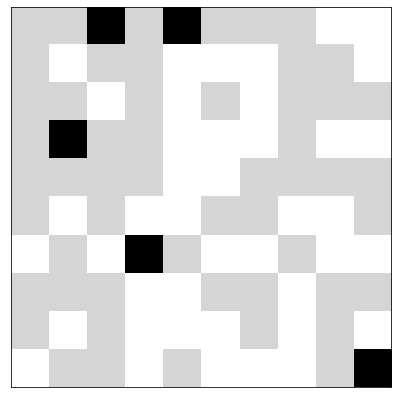

In [22]:
# Define constants that will be used in simulation
H = 10
W = 10
N_ROBOTS = 5
P_BOXES = 0.53
BOX_STACK_LIMIT = 5
TIME_LIMIT = 400
actual_time = 0

# Create model with constants
model = CleaningModel(H, W, N_ROBOTS, P_BOXES, BOX_STACK_LIMIT)

# Run simulation under time limit or until fully cleaned
while actual_time < TIME_LIMIT and model.num_boxes > model.full_stacks * BOX_STACK_LIMIT - N_ROBOTS:
    model.step()
    actual_time += 1

# Collect grids from simulation and plot them
all_grid = model.datacollector.get_model_vars_dataframe()
fig, axs = plt.subplots(figsize=(7, 7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap = plt.cm.binary)
def animate(i):
    patch.set_data(all_grid.iloc[i][0])
anim = animation.FuncAnimation(fig, animate, frames = actual_time)


In [23]:
print("Report")
print("Total of boxes: ", model.num_boxes)
if model.num_boxes == model.full_stacks * BOX_STACK_LIMIT - N_ROBOTS:
    print("Warehouse boxes fully stacked in: %i iterations" %(actual_time))
else:
    print("Warehouse boxes partially stacked. %i complete stacks of %i boxes each." %(model.full_stacks, BOX_STACK_LIMIT))
if model.num_invalid_moves > 0:
    print("Robots tried to move but couldn't %i times." %(model.num_invalid_moves))
print("%i Robots moved a total of %i times." %(model.num_robots, model.num_total_moves))

anim

Report
Total of boxes:  53
Warehouse boxes partially stacked. 10 complete stacks of 5 boxes each.
5 Robots moved a total of 2000 times.
